In [1]:
import math
import torch
import gpytorch
from cox_process import CoxProcess
from poisson_process import PoissonProcess
import sys
sys.path.append("../")
from kernels import SpaceKernel
import matplotlib.pyplot as plt

In [2]:
torch.random.manual_seed(88)

## Set up training data ##

In [3]:
intense_pts = torch.linspace(0, 10, 50).unsqueeze(-1)

log_intense_vals = 3 * torch.sin(0.3*(intense_pts)) - 1

In [4]:
proc = PoissonProcess(intense_pts, log_intensity=log_intense_vals)
sim = proc.simulate()

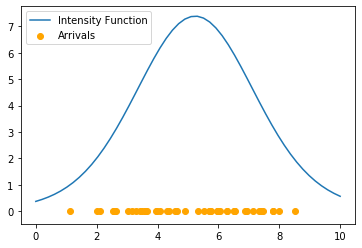

In [5]:
plt.plot(intense_pts, log_intense_vals.exp(), label="Intensity Function")
plt.scatter(sim, torch.zeros_like(sim), label="Arrivals", color="orange")
plt.legend(loc="upper left")

## Test Stable Inference

In [6]:
cox_proc = CoxProcess(intensity_grid=intense_pts, observations=sim)

#### Simulate

In [7]:
inferred = cox_proc.learn_intensity(sim, iters=3)

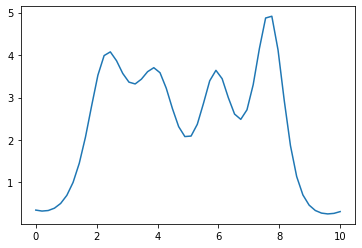

In [8]:
plt.plot(intense_pts, inferred.detach().exp())

In [9]:
cox_proc.learn_hypers()

1.0429192781448364
1.0012164115905762
0.9626282453536987
0.9262495636940002
0.8916610479354858
0.8584641218185425
0.8260260820388794
0.7937359809875488
0.7612833380699158
0.7286084890365601
0.6957796216011047
0.6629102230072021
0.6301156282424927
0.5974931120872498
0.5651122331619263
0.5330091118812561
0.5011822581291199
0.4695851802825928
0.4381140172481537
0.40658217668533325
0.374675989151001
0.3419148921966553
0.3076912760734558
0.2715369462966919
0.23363663256168365
0.1951468586921692
0.15774734318256378
0.12244613468647003
0.0884317010641098
0.053601838648319244
0.016640853136777878
-0.02201026864349842
-0.06075332686305046
-0.09780921787023544
-0.1324363648891449
-0.1659494787454605
-0.20070305466651917
-0.23738349974155426
-0.2744610607624054
-0.3101440370082855
-0.3443394601345062
-0.3786306083202362
-0.4142734408378601
-0.45088890194892883
-0.48695793747901917
-0.5214223265647888
-0.5551490187644958
-0.5898468494415283
-0.6252686381340027
-0.6597341299057007
-0.69296181201934

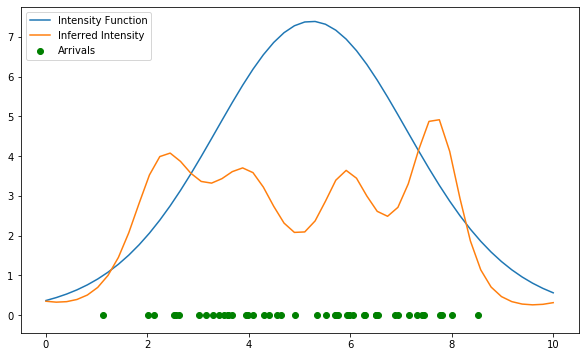

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(intense_pts, log_intense_vals.exp(), label="Intensity Function")
plt.scatter(sim.squeeze(), torch.zeros_like(sim), label="Arrivals", color="green")
plt.plot(intense_pts, inferred.detach().exp(), label="Inferred Intensity")
plt.legend(loc="upper left")